# Tutorial 0: ZenML Quickstart

This tutorial demonstrates the complete workflow for training a model with ZenML
and visualizing the results.

**Why ZenML?** ZenML manages the entire ML pipeline lifecycle - it tracks
experiments, caches step outputs, and ensures reproducibility. By storing
artifacts (models, data, predictions) in ZenML, we can re-run training once
and then quickly iterate on analysis and visualization without re-training. 
It also supports easily adding on automatic parameter tuners like Optuna 
that we'll see in subsequent notebook examples.



In [1]:
import torch

from pioneerml.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)
from pioneerml.zenml import load_step_output
from pioneerml.zenml import utils as zenml_utils
from pioneerml.zenml.pipelines import quickstart_pipeline

# Initialize ZenML for notebook use
# setup_zenml_for_notebook automatically finds the project root by searching
# upward for .zen or .zenml directories, ensuring we use the root configuration.
# use_in_memory=True creates a temporary in-memory SQLite store, perfect for
# tutorials where we don't need persistent artifact storage.
zenml_client = zenml_utils.setup_zenml_for_notebook(use_in_memory=True)
print(f"ZenML initialized with stack: {zenml_client.active_stack_model.name}")



ZenML initialized with stack: default


## Run the Training Pipeline

Here we execute the complete ZenML training pipeline. The pipeline consists of
several steps:

1. **build_datamodule**: Creates synthetic graph data and splits it into train/val sets
2. **build_module**: Instantiates the GroupClassifier model wrapped in a Lightning module
3. **train_module**: Trains the model using PyTorch Lightning (auto-detects CPU/GPU)
4. **collect_predictions**: Runs inference on the validation set to get predictions and targets

**Why use `enable_cache=False`?** This ensures the pipeline runs fresh each time,
which is useful for tutorials. In production, you'd typically enable caching to
skip re-running unchanged steps.

After the pipeline completes, we load the artifacts (trained model, datamodule,
predictions, targets) using `load_step_output`. These artifacts are stored by
ZenML and can be reloaded anytime without re-running the pipeline - this makes
notebooks fast and interactive.



In [2]:
run = quickstart_pipeline.with_options(enable_cache=False)()
print(f"Pipeline run status: {run.status}")

trained_module = load_step_output(run, "train_module")
datamodule = load_step_output(run, "build_datamodule")
predictions = load_step_output(run, "collect_predictions", index=0)
targets = load_step_output(run, "collect_predictions", index=1)

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the quickstart_pipeline run.")

trained_module.eval()
datamodule.setup(stage="fit")
device = next(trained_module.parameters()).device
print(f"Loaded artifacts from run {run.name} (device={device})")



Initiating a new run for the pipeline: quickstart_pipeline.
Caching is disabled by default for quickstart_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  orchestrator: default
  deployer: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_datamodule has started.
Step build_datamodule has finished in 0.234s.
Step build_module has started.
Step build_module has finished in 0.211s.
Step train_module has started.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | GroupClassifier   | 1.1 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.522     Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[train_module] /home/jack/miniconda3/envs/pioneerml/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_module] /home/jack/miniconda3/envs/pioneerml/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Step train_module has finished in 2.833s.
Step collect_predictions has started.
Step collect_predictions has finished in 1.433s.
Pipeline run has finished in 8.920s.
Pipeline run status: completed
Loaded artifacts from run quickstart_pipeline-2025_11_25-04_11_50_238041 (device=cpu)


## Verify Predictions Were Collected

The `collect_predictions` step in the pipeline has already run inference and
collected predictions and targets. This cell simply verifies how many samples
were processed. The predictions are raw **logits** (model outputs *before* any sigmoid), and targets
are one-hot encoded class labels—both ready for evaluation metrics and plots.

A **logit** is the unnormalized score a model produces for each class. It is a real number
$( z \in (-\infty, \infty) )$ that becomes a probability only after applying a sigmoid:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

Positive logits correspond to probabilities above 0.5, negative logits correspond to probabilities below 0.5, and a logit of 0 maps to 0.5.

In [3]:
print(f"Collected predictions for {len(targets)} samples via pipeline step.")

Collected predictions for 64 samples via pipeline step.


# **Training Diagnostics Overview**

This section summarizes four core diagnostics produced during training: **Loss Curves**, **Confusion Matrices**, **ROC Curves**, and **Precision–Recall Curves**.
Each plot captures a different property of model behavior.

---


## **1. Loss Curves**

**Purpose:** Track optimization progress and generalization.

**How it's computed:**

* `train_epoch_loss_history`: average loss per training epoch
* `val_epoch_loss_history`: average loss per validation epoch

**Plot:**

* **X-axis:** epoch index
* **Y-axis:** loss value
* Two lines: Training loss vs. Validation loss.

**How to interpret:**

* **Both curves decreasing together:** normal learning.
* **Training ↓ but validation ↑:** overfitting.
* **Both curves flat:** optimization stuck (bad LR, architecture, data issues).
* **Large train–val gap:** high variance model or insufficient regularization.


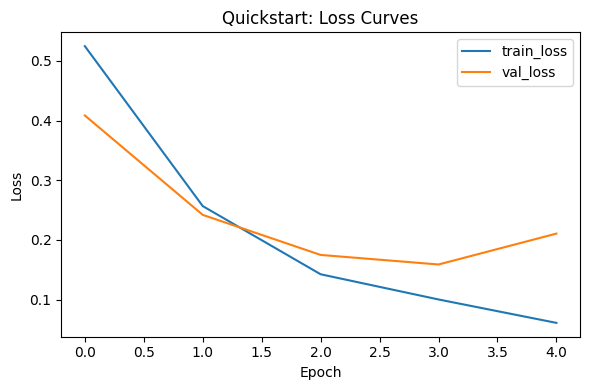

In [4]:
plot_loss_curves(trained_module, title="Quickstart: Loss Curves", show=True)

## **2. Multilabel Confusion Matrices**

**Purpose:** Evaluate binary classification quality for each class independently.

**How it's computed:**

* Apply `sigmoid` to logits.
* Threshold at **0.5** to get binary decisions.
* Compare predicted vs. true one-hot labels.
* Build a **2×2 confusion matrix per class**:

  * True Negative (TN)
  * False Positive (FP)
  * False Negative (FN)
  * True Positive (TP)

**Plot:**
Each class gets a small 2×2 heatmap (normalized so cells sum to 1).

**How to interpret:**

* **Strong diagonal (TN + TP dominant):** class is well-separated.
* **Bright FP cell:** model incorrectly predicts this class too often.
* **Bright FN cell:** model misses true instances of this class.
* **Upper–right or lower–left dominance:** strong bias toward predicting/not predicting the class.

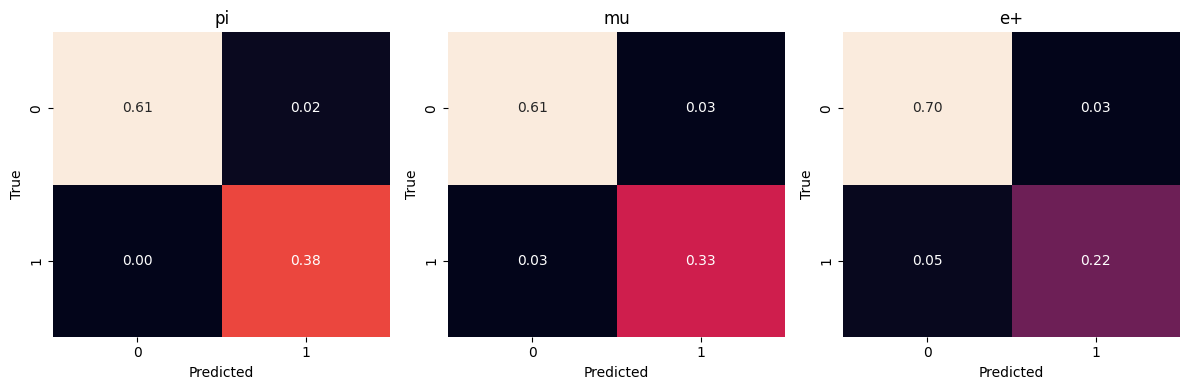

In [5]:
plot_multilabel_confusion_matrix(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    threshold=0.5,
    normalize=True,
    save_path=None,
    show=True,
)

## **3. ROC Curves**

**Purpose:** Measure the model’s ranking ability for each class.

**How it's computed:**

* Sweep a threshold across `[0, 1]` on `sigmoid(probabilities)`
* Compute:

  * **TPR = TP / (TP + FN)**
  * **FPR = FP / (FP + TN)**

**Plot:**

* **X-axis:** False Positive Rate
* **Y-axis:** True Positive Rate
* **AUC (Area Under Curve):** summary statistic for each class.

**How to interpret:**

* **Curve close to top-left + high AUC:** strong ranking quality.
* **Curve along diagonal:** random classifier.
* **Curves crossing:** instability or data scarcity for that class.

ROC is insensitive to class imbalance.

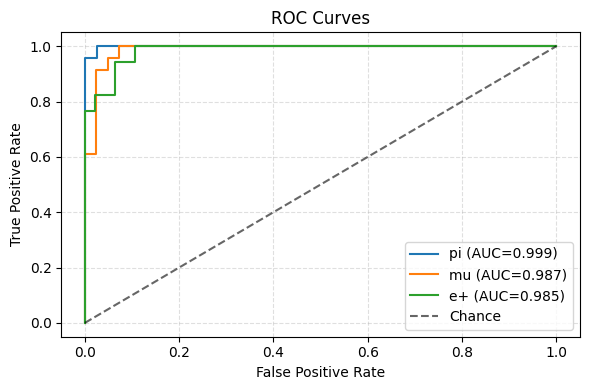

In [6]:
plot_roc_curves(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    save_path=None,
    show=True,
)

## **4. Precision–Recall Curves**

**Purpose:** Evaluate retrieval quality under class imbalance.

**How it's computed:**

* Sweep thresholds over class probabilities.
* For each threshold compute:

  * **Precision = TP / (TP + FP)**
  * **Recall = TP / (TP + FN)**
* Compute **Average Precision (AP)** as area under the curve.

**Plot:**

* **X-axis:** Recall
* **Y-axis:** Precision
* One curve per class.

**How to interpret:**

* **High curve + high AP:** model retrieves most positives without many false alarms.
* **Precision drops sharply at high recall:** model must accept many false positives to capture all positives.
* **Flat low curve:** class is difficult or heavily imbalanced.

PR curves are more informative than ROC when positives are rare.

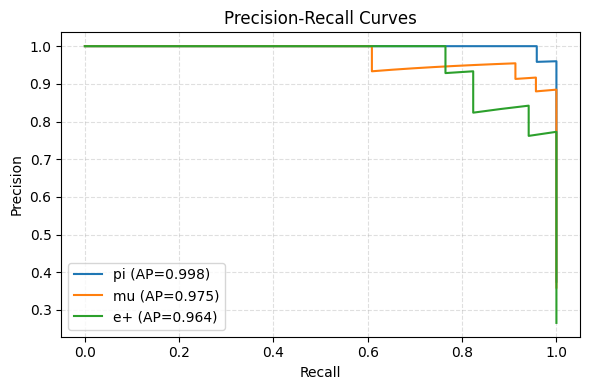

In [7]:
plot_precision_recall_curves(
    predictions=predictions,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    save_path=None,
    show=True,
)